## <u>Project II - Micaela Gutiérrez Coll<u> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

<AxesSubplot:xlabel='PTS', ylabel='Salary'>

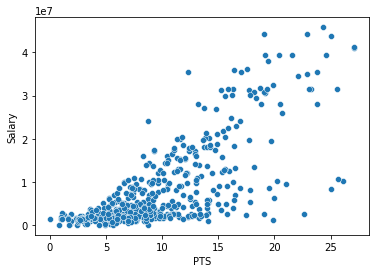

In [3]:
# Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary
sns.scatterplot(data=data, x="PTS", y="Salary", palette="pastel") 

<AxesSubplot:xlabel='REB', ylabel='Salary'>

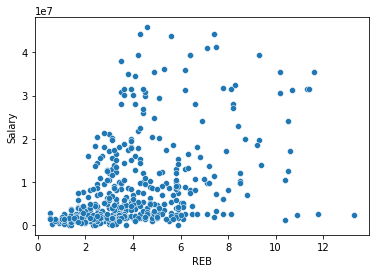

In [4]:
sns.scatterplot(data=data, x="REB", y="Salary", palette="pastel") 

<AxesSubplot:xlabel='AST', ylabel='Salary'>

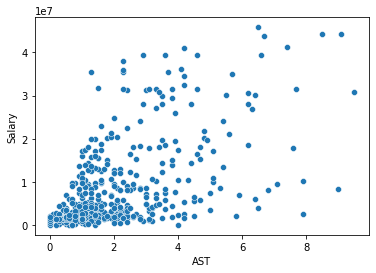

In [5]:
sns.scatterplot(data=data, x="AST", y="Salary", palette="pastel") 

<AxesSubplot:xlabel='STL', ylabel='Salary'>

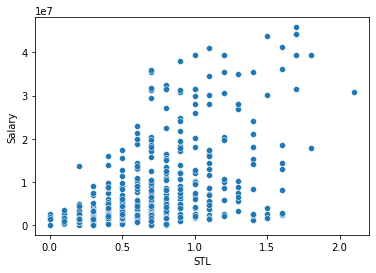

In [6]:
sns.scatterplot(data=data, x="STL", y="Salary", palette="pastel") 

<AxesSubplot:xlabel='BLK', ylabel='Salary'>

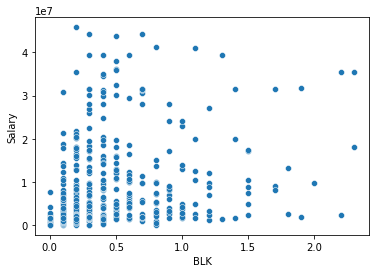

In [7]:
sns.scatterplot(data=data, x="BLK", y="Salary", palette="pastel")

In [8]:
# groupby the salaries to look the distribution
data["Salary"].groupby(by=data["Salary"]).count()

Salary
85578       3
95930       1
102831      1
120083      1
128709      1
           ..
41180544    1
43848000    1
44211146    1
44310840    1
45780966    1
Name: Salary, Length: 332, dtype: int64

##  Splitting the Dataset 

In [9]:
# split data set for train/test. Random State set on 50 for all the project
y = data["Salary"]
X = data.drop(labels=["Salary"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)

## Baseline Model and Evaluation Metric

In [10]:
class BaselineModel():
    """
    A baseline model that always returns the same value, 
    the mean of the players salary in the train data
    """
    
    def fit(self, y_train):
        """
        Fit the training data. 
        
        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
        """
        self.mean = y_train.mean()
    
    def predict(self, X_test):
        """
        Predict salaries 
        
        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
            
        Returns
        -------
        np.ndarray
        a numpy array of the same length as X, with all elements
        equal to the mean salary calculated in fit()
        """
        y_pred = np.full(len(X_test),self.mean)
        return y_pred

In [11]:
# Evaluate the performance of BaselineModel on the test use mean_absolute_error 
evaluate = BaselineModel()
evaluate.fit(y_train) 
y_pred_baseline = evaluate.predict(X_test)
baseline_mae = round(mean_absolute_error(y_test, y_pred_baseline))
print(f"Baseline_mae: {baseline_mae}")

Baseline_mae: 7492454


## Regression with a single variable

In [12]:
# select the variable: PTS
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train["PTS"].array.reshape(-1,1))
X_test_scaled = scaler.transform(X_test["PTS"].array.reshape(-1,1))

In [13]:
# Train a model with SGDRegressor w/ default parameters. 
# Evaluate w/ mean_absolute_error
regressor = SGDRegressor(random_state=50)
regressor.fit(X_train_scaled,y_train)
y_pred_sgd = regressor.predict(X_test_scaled)
default_mae = round(mean_absolute_error(y_test, y_pred_sgd))
print(f"SDG regressor with default parameters - mae -: {default_mae}")

SDG regressor with default parameters - mae -: 5445274


In [14]:
def search_best_hyperparameters(max_iter, eta0):
    
    
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
           
            }
    
    for hyperp in max_iter:
        for i in eta0:
            regressor2 = SGDRegressor(random_state=50, max_iter=hyperp, eta0=i)
            regressor2.fit(X_train_scaled,y_train)
            y_pred_hyper = regressor2.predict(X_test_scaled)
            new_mae = round(mean_absolute_error(y_test,y_pred_hyper))
            
           
            if (result["mae"] == None) or (new_mae < result["mae"]):
                result = {
                "hyperparameters": {"max_iter":hyperp, "eta0":i}, 
                "mae":new_mae
                
                }
                
                
    return result

In [15]:
# differents hyperparameters with differents values
max_iter = [10000, 100000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(f"Best hyperparameters for training & MAE:\n\n{result}")

Best hyperparameters for training & MAE:

{'hyperparameters': {'max_iter': 10000, 'eta0': 0.1}, 'mae': 5360801}


In [16]:
# Compare the results of the baseline model, the SGDRegressor with default parameters 
# and the one with the best combination of hyperparameters 

print("Results Comparition:\n")
print(f"Baseline: {baseline_mae}\n")
print(f"SGDRegressor: {default_mae}\n")
print(f"Combination of hyperparameters: {result['mae']}")

Results Comparition:

Baseline: 7492454

SGDRegressor: 5445274

Combination of hyperparameters: 5360801


In [17]:
# select the best hyperparameters
regressor = SGDRegressor(random_state=50, max_iter=100000, eta0=0.1)
regressor.fit(X_train_scaled,y_train)

SGDRegressor(eta0=0.1, max_iter=100000, random_state=50)

<u>Multivariate Linear Regression</u>

In [18]:
# Create a copy of the dataset (player id as an index):

copy_data = data.copy()
copy_data = copy_data[["PERSON_ID","PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", 
                       "DRAFT_NUMBER", "TEAM_NAME", "Salary"
                     ]]
copy_data = copy_data.set_index("PERSON_ID")
copy_data.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
203500,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171
1628389,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550
1630583,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520
200746,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691


<u>Feature Engineering</u>

In [19]:
# Binning the DRAFT_NUMBER feature:

# - 0 : undrafted
# - 1 to 15: firstround_lottery
# - 15 to 30: firstround_non_lottery
# - 30 to 60: second_round

In [20]:
# to see all the columns
pd.options.display.max_columns = None

In [21]:
# fill the Nan and select type int for the column "DRAFT_NUMBER"
copy_data["DRAFT_NUMBER"] = copy_data["DRAFT_NUMBER"].fillna("Undrafted")
copy_data["DRAFT_NUMBER"] = copy_data["DRAFT_NUMBER"].replace("Undrafted","0")
copy_data["DRAFT_NUMBER"] = copy_data["DRAFT_NUMBER"].astype(int)

In [22]:
# binning the "DRAFT NUMBER"
bins = [0, 1, 15, 30, 60]
bins_name = ["undrafted","firstround_lottery", "firstround_non_lottery", "second_round"]
copy_data["DRAFT"] = pd.cut(copy_data["DRAFT_NUMBER"], bins=bins, labels=bins_name, 
                            ordered=False, include_lowest=True, right=False)

In [23]:
# drop the original column "DRAFT NUMBER"
copy_data.drop(columns= ["DRAFT_NUMBER"], inplace=True, axis=1)

In [24]:
# Encode the categorical features: DRAFT, POSITION and TEAM_NAME

# encode feature DRAFT
draft_categ = pd.get_dummies(copy_data['DRAFT'])

In [25]:
# encode the feature POSITION
position_categ = pd.get_dummies(copy_data['POSITION'])

In [26]:
# encode the feature TEAM NAME
team_categ = pd.get_dummies(copy_data['TEAM_NAME'])

In [27]:
# merge the feature encode with the dataset
new_data = copy_data.merge(draft_categ, on="PERSON_ID")
new_data = new_data.merge(position_categ, on="PERSON_ID")
new_data = new_data.merge(team_categ, on="PERSON_ID")

In [28]:
# drop the originals columns "undrafted", "POSITION", "TEAM_NAME"
new_data.drop(columns= ["undrafted", "POSITION", "TEAM_NAME"], inplace=True, axis=1)
new_data.head()

,PTS,REB,AST,BLK,SEASON_EXP,Salary,DRAFT,firstround_lottery,firstround_non_lottery,second_round,Center,Forward,Guard,76ers,Bucks,Bulls,Cavaliers,Celtics,Clippers,Grizzlies,Hawks,Heat,Hornets,Jazz,Kings,Knicks,Lakers,Magic,Mavericks,Nets,Nuggets,Pacers,Pelicans,Pistons,Raptors,Rockets,Spurs,Suns,Thunder,Timberwolves,Trail Blazers,Warriors,Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,2711280,firstround_non_lottery,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
203500,9.3,7.9,1.4,0.9,8,17073171,firstround_lottery,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1628389,13.2,8.2,3.5,0.9,4,28103550,firstround_lottery,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1630583,3.3,2.4,0.5,0.3,0,1994520,second_round,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200746,19.1,8.1,1.9,1.1,15,2641691,firstround_lottery,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


<u>Modeling</u>

In [29]:
# Split the dataset into train and test
y = new_data["Salary"]
X = new_data.drop(labels=["Salary"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)

In [30]:
# Perform feature scaling in all the numerical 
# features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

numerical_feature = ["PTS","REB", "AST", "BLK", "SEASON_EXP"]

scaler = StandardScaler(copy=False)
X_train[numerical_feature] = scaler.fit_transform(X_train[numerical_feature])
X_test[numerical_feature] = scaler.transform(X_test[numerical_feature])

In [31]:
# Function to train a SGDRegressor model with the new dataset, 
# trying different hyperparameters, and selecting the one that performs the best.

def new_data_sgd(max_iter, eta0, alpha):
    
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None, "alpha": None}, 
        "mae": None
    }
    
    for hyperp in max_iter:
        for i in eta0:
            for a in alpha:
                sgdr = SGDRegressor(random_state=50, max_iter=hyperp, eta0=i, alpha=a)
                sgdr.fit(X_train[numerical_feature],y_train)
                y_pred_sgdr = sgdr.predict(X_test[numerical_feature])
                mae = round(mean_absolute_error(y_test,y_pred_sgdr))
            
           
                if (result["mae"]==None) or (mae < result["mae"]):
                    
                    result = {
                    "hyperparameters": {"max_iter":hyperp, "eta0":i, "alpha":a}, 
                    "mae":mae
                    }
                
                
    return result



In [32]:
# differents hyperparameters with differents values
max_iter = [1000000, 1500000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alpha = [1, 0.0001, 0.001, 0.1]

result2 = new_data_sgd(max_iter, eta0, alpha)
print(f"Best hyperparameters and MAE: {result2}")

Best hyperparameters and MAE: {'hyperparameters': {'max_iter': 1000000, 'eta0': 0.1, 'alpha': 0.0001}, 'mae': 5264098}


<u>1.16. How did the model performed compared to our univariate models?</u>

The both models with hyperparameters performed better than the univariate models.
    
The last one performed had the best performance, in this case the hyperparameters are: max_iter: 1000000, eta0: 0.0001 and alpha:1.

In [33]:
print("The differents results are:\n")
print(f"Baseline: {baseline_mae}\n")
print(f"SGDRegressor: {default_mae}\n")
print(f"Combination of hyperparameters 1: {result['mae']}\n")
print(f"Combination of hyperparameters 2: {result2['mae']}")

The differents results are:

Baseline: 7492454

SGDRegressor: 5445274

Combination of hyperparameters 1: 5360801

Combination of hyperparameters 2: 5264098


## DecisionTreeRegressor

In [34]:
# Create new model using DecisionTreeRegressor


def model_tree(max_depth, min_samples_leaf, max_features):
    
    result = {
        "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
        "mae": None
    }
    
    for m in max_depth:
        for s in min_samples_leaf:
            for f in max_features:
                tree_reg = DecisionTreeRegressor(random_state=50,max_depth=m, min_samples_leaf=s, max_features=f)
                tree_reg.fit(X_train[numerical_feature],y_train)
                y_pred_tree = tree_reg.predict(X_test[numerical_feature])
                mae = round(mean_absolute_error(y_test,y_pred_tree))
            
           
                if (result["mae"] == None) or (mae < result["mae"]):
                            
                    result = {
                    "hyperparameters": {"max_depth":m, "min_samples_leaf":s, "max_features":f}, 
                    "mae":mae
                    }
                
                
    return result



In [35]:
# differents hyperparameters with differentes values

max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [2,5]

result_tree = model_tree(max_depth, min_samples_leaf, max_features=max_features)
print(f" Results of DTR: {result_tree}")

 Results of DTR: {'hyperparameters': {'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 2}, 'mae': 4132636}


<u>1.18 Compare the results obtained with all the models<u>

In [36]:
print("Differents results:\n")
print(f"Baseline: {baseline_mae}\n")
print(f"SGDRegressor: {default_mae}\n")
print(f"Combination of hyperparameters 2: {result2['mae']}\n")
print(f"DecisionTreeRegressor: {result_tree['mae']}")

Differents results:

Baseline: 7492454

SGDRegressor: 5445274

Combination of hyperparameters 2: 5264098

DecisionTreeRegressor: 4132636


<u>Star or no Star? Predicting players All-NBA selections</u>

<u>Analyzing the data</u>

In [37]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

In [38]:

all_nba_df.head() # number of rows: 14825

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,0.474,0.0,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,0.493,0.0,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,0.518,0.0,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,0.436,0.0,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,0.511,0.0,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0


In [39]:
# number of seasons
n_season = all_nba_df["season"].unique()
print(f"Number of season: {n_season}")

Number of season: ['1990-91' '1991-92' '1992-93' '1993-94' '1994-95' '1995-96' '1996-97'
 '1997-98' '2000-01' '1998-99' '1999-00' '2001-02' '2002-03' '2003-04'
 '2004-05' '2005-06' '2006-07' '2007-08' '2016-17' '2017-18' '2008-09'
 '1987-88' '1988-89' '1989-90' '2012-13' '2013-14' '2014-15' '2015-16'
 '1985-86' '1986-87' '2010-11' '2011-12' '2009-10' '1981-82' '1982-83'
 '1983-84' '1984-85' '1980-81' '1979-80']


In [40]:
# number of players
n_players = all_nba_df["player_id"].nunique()
print(f"Number of players: {n_players}")

Number of players: 2718


In [41]:
# number of players selections and non selections
n_selections = all_nba_df.groupby(all_nba_df["all_nba"])["all_nba"].count()

# 0 - non_selected : 14329
# 1 - selected : 496

<u>Splitting the dataset</u>

In [42]:
# split data set train & test and target

y = all_nba_df["all_nba"]
X = all_nba_df.drop(labels=["all_nba"], axis=1)
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 
               'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'
              ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=50, stratify=y)

<u>Baseline model and Evaluation Metrics</u>

In [43]:
# A simple test. What accuracy would we get if we had a baseline model 
# that always predicted 0 (player not selected to all nba)?


class BaselineModel():
    """
    A baseline model that always returns 
    0 (player not selected to all nba)
    """
    
    def fit(self,X_train, y_train):
      
        self.fit_nba = 0
    
    def predict(self, X_test):
       
        y_pred = np.full(len(X_test), self.fit_nba)
        return y_pred



In [44]:
model = BaselineModel()
model.fit(X_train, y_train) 
y_pred_model = model.predict(X_test)
y_pred_model

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
accuracy_model = accuracy_score(y_test, y_pred_model)
print(f"Accuracy of BaselineModel: {accuracy_model}")

Accuracy of BaselineModel: 0.966501798561151


2.4. <u>What does this tells us about the data and the use of accuracy as an evaluation metric?</u>

The accuracy is very high because the model always predict 0. The accuracy measure the precision of the model, but when the data is unbalanced the accuracy is not a good metric to use.  

In [46]:
# Scale all numerical features in the dataset

columns = ["games", "gamesstarted", "mp","fg_perc", "3p_perc", "2p_perc","ft_perc", "trb", 
           "ast", "stl", "blk", "tov", "pf", "pts"]
scaler = StandardScaler()
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns])

In [47]:
# Train a LogisticRegression with default parameters (baselinemodel)

base_model = LogisticRegression(random_state=50)
base_model.fit(X_train[columns],y_train)
y_pred_model2 = base_model.predict(X_test[columns])

In [48]:
# Evaluate our baseline model using metrics: accuracy, precision, recall, f1 
evaluate1 = accuracy_score(y_test, y_pred_model2)
print(f" Accuracy: {evaluate1}")

 Accuracy: 0.9808902877697842


In [49]:
evaluate2 = precision_score(y_test, y_pred_model2)
print(f"Precision: {evaluate2}")

Precision: 0.8018867924528302


In [50]:
evaluate3 = recall_score(y_test, y_pred_model2)
print(f"Recall: {evaluate3}")

Recall: 0.5704697986577181


In [51]:
evaluate4 = f1_score(y_test, y_pred_model2)
print(f"F1: {evaluate4}")

F1: 0.6666666666666666


<u>Classification</u>

<u>Feature engineering</u>

In [52]:
# encode the Team feature 

# encode X_train
team_encode_train = pd.get_dummies(X_train["team"])

In [53]:
# join X_train with the encode teams
X_train = X_train.join(team_encode_train)

In [54]:
# encode X_test
team_encode_test = pd.get_dummies(X_test["team"])

In [55]:
# join X_test with the encode teams
X_test = X_test.join(team_encode_test)

In [56]:
# drop the original column "team"
X_train.drop(columns=["team"], axis=1, inplace=True)
X_test.drop(columns=["team"], axis=1, inplace=True)

<u>Modeling</u>

In [57]:
# Train a logistic regresion model, find the best hyperparameters for: tol, C and max_iter.

def model_regre (tol, C, max_iter):
    
    result = {
        "hyperparameters": {"tol": None, "C": None, "max_iter": None}, 
        "f1": None, "precision": None, "recall": None
        }
    
    for t in tol:
        for c in C:
            for m in max_iter:
                reg_model = LogisticRegression (random_state=50, tol=t, C=c, max_iter=m)
                reg_model.fit(X_train, y_train)
                y_pred_reg = reg_model.predict(X_test)
                metric_f1 = f1_score(y_test, y_pred_reg)
                metric_prec = precision_score(y_test, y_pred_reg, zero_division=1)
                metric_reca = recall_score(y_test, y_pred_reg)
                

                if (result["f1"] == None) or (metric_f1 > result["f1"]):

                    result = {
                            "hyperparameters": {"tol":t, "C":c, "max_iter":m}, 
                            "f1": metric_f1, "precision": metric_prec, "recall": metric_reca
                            }
    return result              


In [58]:
# differents hyperparameters with differents values
tol = [0.01, 0.001, 0.5]
C = [0.1, 0.01, 0.001, 2.5]
max_iter = [100, 1000, 7000, 50]

result_model_regre = model_regre(tol, C, max_iter)
print(result_model_regre)

{'hyperparameters': {'tol': 0.01, 'C': 2.5, 'max_iter': 100}, 'f1': 0.7054263565891473, 'precision': 0.8348623853211009, 'recall': 0.610738255033557}


<u>Evaluating on New Data</u>

In [59]:
# X_val -> all players season 2018
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)

# y_val -> only players selections all stars 2018
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [60]:
# Create a variable to the both DataSet
X_val = all_nba_2018_df
y_val = all_nba_2018_selections

In [61]:
# Scale the numerical features - not to pass them to the classifier 
# Columns season_id, player_id, player_season, season and season_start (not use to prediction)

In [62]:
# Scale numerical columns of X_val
columns = ["games","gamesstarted","mp","fg_perc", "3p_perc","2p_perc",
           "ft_perc","trb","ast","stl","blk", "tov", "pf", "pts"]

scaler = StandardScaler() # distrib gaussiana / outliers
X_val[columns] = scaler.fit_transform(X_val[columns])
X_val.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,-0.701162,-0.758451,-0.039728,-0.742175,0.219240,0.071257,1.053788,-0.834285,-0.745387,-0.285309,-0.472324,-0.714502,-0.034165,-0.542799
49,49,8,7,Quincy Acy,2018-19,2018,PHO,-1.508104,-0.829977,-0.775633,-1.950619,-1.053897,1.420054,0.015020,-0.439490,-0.632579,-1.254627,0.021427,-0.840731,0.828089,-1.132515
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,-0.585885,-0.794214,-0.742682,-0.849593,0.319751,-1.051394,0.378356,-0.715847,-0.012132,-0.527638,-0.719200,-0.335816,-0.526881,-0.886800
71,71,13,6,Steven Adams,2018-19,2018,OKC,1.181702,2.031082,1.541920,1.388266,-1.945094,0.846613,-0.916610,2.324081,-0.181345,2.137987,1.502680,0.800242,1.074448,0.865968
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,1.258554,0.171394,0.432570,1.218189,-0.604949,0.782000,0.178056,1.455530,0.157080,0.684010,1.008929,0.547785,0.951268,0.046918


In [63]:
# encode teams NBA 2018 - 30 teams
encode_30teams = pd.get_dummies(X_val["team"])

In [64]:
# join DF with statistics and 30 teams
X_val = X_val.join(encode_30teams)
X_val.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,TOT,UTA,WAS
34,34,5,2,Alex Abrines,2018-19,2018,OKC,-0.701162,-0.758451,-0.039728,-0.742175,0.219240,0.071257,1.053788,-0.834285,-0.745387,-0.285309,-0.472324,-0.714502,-0.034165,-0.542799,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49,49,8,7,Quincy Acy,2018-19,2018,PHO,-1.508104,-0.829977,-0.775633,-1.950619,-1.053897,1.420054,0.015020,-0.439490,-0.632579,-1.254627,0.021427,-0.840731,0.828089,-1.132515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,-0.585885,-0.794214,-0.742682,-0.849593,0.319751,-1.051394,0.378356,-0.715847,-0.012132,-0.527638,-0.719200,-0.335816,-0.526881,-0.886800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,71,13,6,Steven Adams,2018-19,2018,OKC,1.181702,2.031082,1.541920,1.388266,-1.945094,0.846613,-0.916610,2.324081,-0.181345,2.137987,1.502680,0.800242,1.074448,0.865968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,1.258554,0.171394,0.432570,1.218189,-0.604949,0.782000,0.178056,1.455530,0.157080,0.684010,1.008929,0.547785,0.951268,0.046918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
# searching 10 teams more of the history of NBA -> total 40 teams (team_encode_train)
X_val[['CHA', 'CHH', 'KCK', 'NJN', 'NOH', 'NOK', 'SDC', 'SEA', 'VAN', 'WSB']]=0

In [66]:
X_val.drop(["season_id","player_id","player_season","player","season",
            "season_start","team"], inplace=True, axis=1)

In [67]:
reg_model = LogisticRegression (random_state=50, tol=0.01, C=2.5, max_iter=100)
reg_model.fit(X_train, y_train)
y_pred2 = reg_model.predict(X_val)

In [68]:
report_precision = precision_score(y_val["all_nba"], y_pred2)
print(f"Precision: {report_precision}")

Precision: 0.6190476190476191


In [69]:
report_recall = recall_score(y_val["all_nba"], y_pred2)
print(f"Recall: {report_recall}")

Recall: 0.8666666666666667


In [70]:
report_f1 = f1_score(y_val["all_nba"], y_pred2)
print(f"F1: {report_f1}")

F1: 0.7222222222222222


## Creating our custom Classifier

In [71]:
# predict with the previous model trained
y_pred_all = reg_model.predict_proba(X_val)[:,1]

In [72]:
# probabilities to selected the players
probabilities = pd.DataFrame(y_pred_all, columns=["probabilities"])
probabilities

,probabilities
0,3.554858e-08
1,6.697385e-08
2,1.944963e-08
3,6.853071e-03
4,8.147405e-05
...,...
525,6.643366e-02
526,1.629770e-04
527,1.400658e-06
528,1.207791e-05


In [73]:
# reset the index of the dataset
all_nba_2018_selections = all_nba_2018_selections.reset_index()

In [74]:
# join the dataset with the probabilities
players_proba = all_nba_2018_selections.join(probabilities)

In [75]:
players_proba.head()

,index,player_id,player,all_nba,probabilities
0,34,5,Alex Abrines,0,3.554858e-08
1,49,8,Quincy Acy,0,6.697385e-08
2,70,10,Jaylen Adams,0,1.944963e-08
3,71,13,Steven Adams,0,6.853071e-03
4,79,15,Bam Adebayo,0,8.147405e-05


In [76]:
# round to 3 decimals the probabilities
players_proba["probabilities"] = players_proba["probabilities"].round(decimals=3)

In [77]:
# drop the column "all_nba"
players_proba.drop(columns={"index","all_nba"}, inplace=True)

In [78]:
# Sort the dataset by probabilities and show the 15 players with 
# higher probability to have been selected
players_proba.sort_values(by=["probabilities"], axis=0,
                          inplace=True, ascending=False, na_position="last")

In [79]:
# Players actually selected from the all_nba_2018_selections dataset
players_selected_2018 = all_nba_2018_selections["all_nba"] == 1
players_selected_2018 = all_nba_2018_selections[players_selected_2018]
print("15 players actually selected:")
players_selected_2018

15 players actually selected:


,index,player_id,player,all_nba
17,453,83,Giannis Antetokounmpo,1
123,3168,570,Stephen Curry,1
149,3908,695,Kevin Durant,1
154,4145,740,Joel Embiid,1
182,4895,884,Paul George,1
186,5016,909,Rudy Gobert,1
201,5399,979,Blake Griffin,1
205,5604,1024,James Harden,1
248,6634,1204,Kyrie Irving,1
257,6857,1240,LeBron James,1


In [80]:
# Players selected with the model
players_15_predict = players_proba[0:16]
print("15 players selected with the model:")
players_15_predict 

15 players selected with the model:


,player_id,player,probabilities
205,1024,James Harden,1.000
17,83,Giannis Antetokounmpo,0.999
257,1240,LeBron James,0.998
125,587,Anthony Davis,0.996
154,740,Joel Embiid,0.990
491,2572,Nikola Vucevic,0.950
300,1492,Kawhi Leonard,0.905
479,2501,Karl-Anthony Towns,0.897
149,695,Kevin Durant,0.895
505,2648,Russell Westbrook,0.858


In [81]:
# Players actually selected missing from my predictions
set(players_selected_2018["player"]) - set(players_15_predict["player"])

{'Blake Griffin',
 'Damian Lillard',
 'Kyrie Irving',
 'Paul George',
 'Stephen Curry'}

In [82]:
# Players in my predictions not selected 
set(players_15_predict["player"]) - set(players_selected_2018["player"])

{'Anthony Davis',
 'Ben Simmons',
 'Clint Capela',
 'Karl-Anthony Towns',
 'LaMarcus Aldridge',
 'Nikola Vucevic'}

In [83]:
class AllNbaSingleSeasonClassifier():
    
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        
        
        self._model = model
        
    
    def predict(self, X, val):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results 
            based on the players with most probabilities of
            beign selected
        """
        
    
        y = self._model.predict_proba(X)[:,1]
        y = pd.DataFrame(y, columns=["probabilities"])
        y = y.round(decimals=3)
        y = y.reset_index(drop=True)
        val = val.reset_index(drop=True)
        y = y.join(val["player"])
        y["selection"] = 0
        y.loc[y.nlargest(15, "probabilities").index, "selection"] = 1
        y = y["selection"].to_numpy()
        

        return y

In [84]:
clasifier = AllNbaSingleSeasonClassifier(reg_model)

In [85]:
prediction = clasifier.predict(X_val, y_val)

In [86]:
prediction

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [87]:
# Use the new classifier to make predictions and evaluate the result
# with precision, recall and f1

In [88]:
reports1 = f1_score(y_val["all_nba"], prediction)
print(f"F1: {reports1}")

F1: 0.6666666666666666


In [89]:
reports2 = recall_score(y_val["all_nba"], prediction)
print(f"Recall: {reports2}")

Recall: 0.6666666666666666


In [90]:
reports3 = precision_score(y_val["all_nba"], prediction)
print(f"Precision: {reports3}")

Precision: 0.6666666666666666
